In [2]:
#encoding: utf-8
from __future__ import print_function
import os
from config import config as cfg
from proc.preproc import (describe_data, load_from_text,
                          split_patients_by_patient_ID,
                          get_class_weight)
from proc.gennerator import ImageGeneratorFromPath
from matplotlib import pyplot as plt
from skimage.util.montage import montage2d
from proc.image import ImageTransformer
from model import Xception_CBAM
from utils import makedir
from keras import backend as K
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
cfg.data_root = 'I:/chest_xray'

def show_batch_sample(gen, path=None):
    batch_x, batch_y = next(gen)
    x = montage2d(np.squeeze(batch_x[:, :, :, 0]))
    fig = plt.figure(figsize=(15, 15))
    plt.imshow(x, cmap='bone')
    plt.axis('off')
    if path:
        plt.savefig(path)
    else:
        plt.show()
train_val_df, test_df, xray14_labels = load_from_text(cfg.data_root)
train_df, val_df = split_patients_by_patient_ID(train_val_df, 4, cfg.random_seed)
print('*' * 40, 'val data', '*' * 40)
describe_data(val_df, xray14_labels)
val_transformer = ImageTransformer(samplewise_normalization=True)
val_gen = ImageGeneratorFromPath(val_transformer, 
                                 val_df['path'],
                                 val_df['xray14_vec'],
                                 shuffle=False,
                                 target_size=cfg.input_shape[:-1],
                                 batch_size=1,
                                 color_mode='rgb')

********************************************************************************
There are total  86523  train and val data
There are total  25595  test data
**************************************** all data ****************************************
There are total  112120  images.
Infiltration        ---19894
Effusion            ---13317
Atelectasis         ---11559
Nodule              ---6331
Mass                ---5782
Pneumothorax        ---5302
Consolidation       ---4667
Pleural_Thickening  ---3385
Cardiomegaly        ---2776
Emphysema           ---2516
Edema               ---2303
Fibrosis            ---1686
Pneumonia           ---1431
Hernia              ---227
**************************************** train val data ****************************************
There are total  86523  images.
Infiltration        ---13782
Effusion            ---8659
Atelectasis         ---8280
Nodule              ---4708
Mass                ---4033
Consolidation       ---2852
Pneumothorax        ---263

In [3]:
from config import config as cfg

In [4]:
def get_pos(gen):
    pos_l00 = []
    i = 0
    while 1:
        image, label = next(gen)
        if(np.sum(label) > 0):
            pos_l00.append([image, label])
            i = i + 1
            if i == 100:
                break
    return pos_l00

In [5]:
pos_l00 = get_pos(val_gen)

In [6]:
image, label = pos_l00[70]
label = label[:]
image = np.squeeze(image)
pos_cls = []
i = 0
for xray_cls in label[0]:
    if xray_cls > 0:
        pos_cls.append(xray14_labels[i])
    i = i + 1
print(pos_cls)

['Effusion']


In [9]:
model = Xception_CBAM(cfg.input_shape, include_top=True, 
                              n_class=len(xray14_labels),
                              pretrain_weights='./logs/train_epoch_72.hdf5',
                              layer_trainable=True)
model.load_weights('./logs/train_epoch_72.hdf5')
model.trainable = False

weight path does not exist!


In [10]:
def cam_model(model):
    inputs_img = model.layers[0].input
    saliency1 = model.get_layer('cbam1_spatial_sliency').output
    saliency2 = model.get_layer('cbam2_spatial_sliency').output
    func = K.function([inputs_img], [saliency1, saliency2])
    return func

In [11]:
train_x, train_y = val_gen[0]
print(train_x.shape)

(1, 256, 256, 3)


In [18]:
get_saliency = cam_model(model)
[saliency1, saliency2] = get_saliency([train_x])
predict = model.predict_on_batch(train_x)
print(train_y)
print(predict > 0.1)

[[0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]]
[[ True False False False False False False False  True False False False
  False False]]


In [57]:
print(predict)
print(xray14_labels)

[[0.2711693  0.06785741 0.01878405 0.00720345 0.05056421 0.08362022
  0.03811451 0.02623367 0.17442395 0.01274038 0.04365396 0.04819718
  0.011421   0.08313294]]
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [19]:
import cv2
print(saliency1.shape)
saliency1 = cv2.resize(np.squeeze(saliency1), image.shape[:2])
saliency2 = cv2.resize(np.squeeze(saliency2), image.shape[:2])

(1, 16, 16, 1)


In [14]:
saliency2.shape

(256, 256)

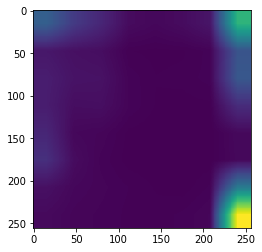

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(saliency2)

In [24]:
org_img = (image - image.min()) / (image.max() - image.min()) 

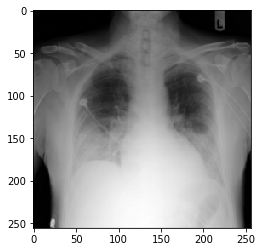

In [25]:
heatmap = cv2.applyColorMap(np.uint8(255 * saliency2), cv2.COLORMAP_JET)
heatmap[np.where(saliency2 < 0.2)] = 0
saliency_img = heatmap * 0.5 + org_img
plt.imshow(saliency_img)

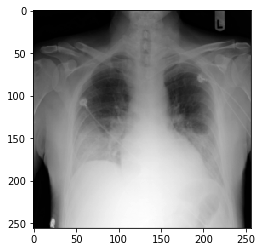

In [23]:
plt.imshow(org_img)

In [25]:
for layer in model.layers:
    if 'cbam' in layer.name:
        print(layer.name, '--- is not trainable.')

cbam1_channel_squeeze --- is not trainable.
cbam1_channel_extraction --- is not trainable.
cbam1_spatial_sliency --- is not trainable.
cbam2_channel_squeeze --- is not trainable.
cbam2_channel_extraction --- is not trainable.
cbam2_spatial_sliency --- is not trainable.


In [158]:
import pandas as pd
pd.options.display.max_columns = 100
train_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,xray14_vec
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,I:/chest_xray\images\images001\00000001_000.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,I:/chest_xray\images\images001\00000001_001.png,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,I:/chest_xray\images\images001\00000001_002.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,0.171,I:/chest_xray\images\images001\00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12,00000004_000.png,Mass|Nodule,0,4,82,M,AP,2500,2048,0.168,0.168,I:/chest_xray\images\images001\00000004_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [159]:
train_df['xray14_vec'].values[0]

array([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0], dtype=object)

In [163]:
np.array(train_df['xray14_vec'].values[0], dtype=np.float32)

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)